# Featureset evaluation
Evaluation of different featuresets for all algorithms.

## Preparation
- Imports
- Data preprocessing
- Target encoding

In [1]:
from pandas import DataFrame
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)

df = pd.read_csv('../0_data/DEvideos.csv',
    low_memory=False)

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
df['publish_month'] = df['publish_time'].map(lambda x: x.month)
df['publish_year'] = df['publish_time'].map(lambda x: x.year)
df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

def assign_target_category(row):
    if row['days_until_trending'] == 0: 
        return 0
    elif row['days_until_trending'] == 1:
        return 1
    elif row['days_until_trending'] == 2:
        return 2
    elif row['days_until_trending'] <= 5:
        return 3
    else:
        return 6

df['target_category'] = df.apply(assign_target_category, axis=1)
df['channel_title'] = df['channel_title'].astype('category')

tag_df = pd.read_csv('../0_data/DEtags.csv')
tag_df = tag_df.set_index('tag')
def calculate_tag_factor(tag_string, tag_data):
    tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
    return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)
    
df['tag_factors'] = df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
df['tag_factors'] = df.apply(lambda row: 0 if np.isnan(row['tag_factors']) else row['tag_factors'], axis=1)

N = len(df)
dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
for column in df.columns:
    numberOfUniqueValues = df[column].nunique()
    if numberOfUniqueValues < 2:
        dropColumns.append(column)
    elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
        dropColumns.append(column)
    elif df[column].isna().sum() / N > 0.95:
        dropColumns.append(column)
        
df.drop(columns=dropColumns, inplace=True)

target = df['target_category'].astype(str)
y_label_encoder = preprocessing.LabelEncoder()
y_label_encoder.fit(target)
y = y_label_encoder.transform(target)

## Declare classifiers

In [2]:
classifiers = []

classifiers.append(['Decision Tree', DecisionTreeClassifier()])
classifiers.append(['K Nearest Neighbor', KNeighborsClassifier(n_jobs=-1)])
classifiers.append(['Random Forest', RandomForestClassifier(n_jobs=-1)])
classifiers.append(['XG Boost', XGBClassifier(use_label_encoder=False, verbosity=0)])

classifiers.append(['Decision Tree (optimized)', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=50, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, splitter='best')])
classifiers.append(['K Nearest Neighbor (optimized)', KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree', leaf_size=20, n_neighbors=8, p=1, weights='uniform')])
classifiers.append(['Random Forest (optimized)', RandomForestClassifier(n_jobs=-1, class_weight=None, criterion='gini', max_depth=9, max_features='log2', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=200)])
classifiers.append(['XG Boost (optimized)', XGBClassifier(use_label_encoder=False, verbosity=0, booster='gbtree', colsample_bylevel=0.75, colsample_bynode=1, colsample_bytree=1, gamma=2, learning_rate=0.5, max_delta_step=0, max_depth=6, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=0, subsample=1, tree_method='hist')])

classifiers.append(['K Nearest Neighbor (maxed)', KNeighborsClassifier(n_jobs=-1, n_neighbors=300)])
classifiers.append(['Random Forest (maxed) 1', RandomForestClassifier(n_jobs=-1, max_depth=18, n_estimators=200)])
classifiers.append(['Random Forest (maxed) 2', RandomForestClassifier(n_jobs=-1, max_depth=18, n_estimators=1000)])

## Iterate over featuresets

In [3]:
%%time
featuresets = [['tag_factors'],
['views', 'publish_hour'],
['views', 'publish_hour', 'tag_factors'],
['views', 'publish_hour', 'ratings_per_view'],
['views', 'publish_hour', 'ratings_per_view', 'tag_factors'],
['views', 'publish_hour', 'ratings_per_view', 'comments_per_view'],
['views', 'publish_hour', 'ratings_per_view', 'comments_per_view', 'tag_factors']]

def join_features(featureset):
    jf = ''
    for feature in featureset:
        jf += feature[:1] + ','
    return jf[:-1]

results = pd.DataFrame(columns=['algorithm', 'accuracy', 'execution_time', 'featureset'])

for featureset in featuresets:
    # Encode features
    x_df = DataFrame(index=df.index)
    for feature in featureset:
        feature_data = df[feature]
        if df[feature].dtype.name == 'category':
            x_label_encoder = preprocessing.LabelEncoder()
            x_label_encoder.fit(feature_data.astype(str))
            x_df[feature] = x_label_encoder.transform(feature_data)
        elif df[feature].dtype.name == 'datetime64[ns]':
            x_df[feature] = feature_data.to_seconds()
        elif df[feature].dtype.name == 'bool':
            x_df[feature] = int(feature_data)
        else:
            x_df[feature] = feature_data

    x = np.reshape(x_df, (-1, len(x_df.columns)))

    # Create data subsets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=0)

    # Train model and predict test data
    for classifier in classifiers:
        start_time = time.time()
        classifier[1].fit(x_train, y_train)
        y_pred = classifier[1].predict(x_test)
        execution_time = time.time() - start_time
        result = {'algorithm': classifier[0], 'accuracy': accuracy_score(y_test, y_pred), 'execution_time': execution_time, 'featureset': join_features(featureset)}
        results = results.append(result, ignore_index=True)

Wall time: 1min 33s


## Results

**featureset**:
- ``t``: tag_factors
- ``v``: views
- ``p``: publish_hour
- ``r``: ratings_per_view
- ``c``: comments_per_view

In [4]:
results.head(15)

,algorithm,accuracy,execution_time,featureset
0,Decision Tree,0.511508,0.047997,t
1,K Nearest Neighbor,0.576579,0.385999,t
2,Random Forest,0.506366,0.426000,t
3,XG Boost,0.612329,2.265000,t
4,Decision Tree (optimized),0.619001,0.025000,t
5,K Nearest Neighbor (optimized),0.589618,0.422998,t
6,Random Forest (optimized),0.619001,0.548001,t
7,XG Boost (optimized),0.620225,0.570001,t
8,K Nearest Neighbor (maxed),0.621511,0.768000,t
9,Random Forest (maxed) 1,0.580436,0.695001,t


### Default and optimized

Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

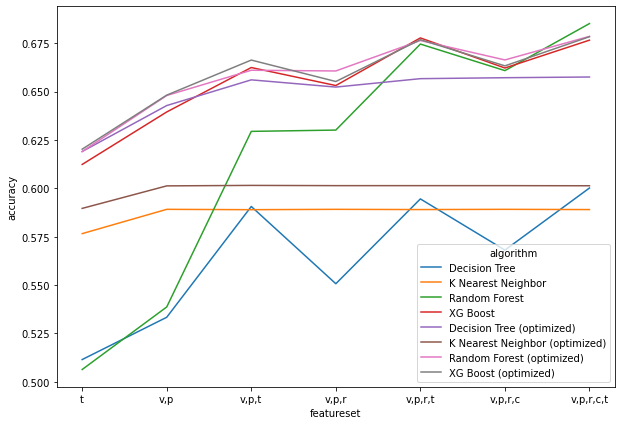

In [5]:
sns.lineplot(data=results[results['algorithm'].str.contains('(maxed)') == False], x='featureset', y='accuracy', hue='algorithm')

Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

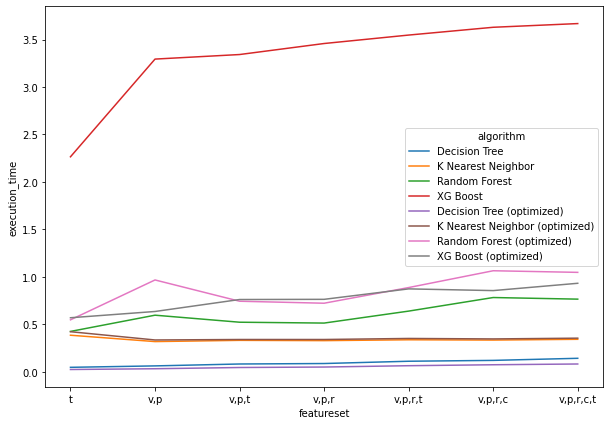

In [6]:
sns.lineplot(data=results[results['algorithm'].str.contains('(maxed)') == False], x='featureset', y='execution_time', hue='algorithm')

###  Decision tree

Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

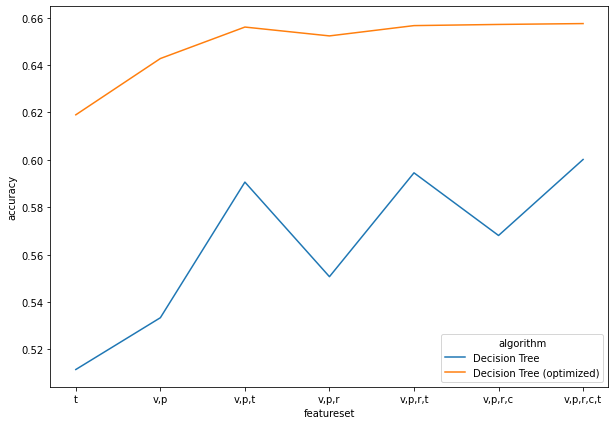

In [7]:
results_dt = results[results['algorithm'].str.contains('Decision Tree')]
sns.lineplot(data=results_dt, x='featureset', y='accuracy', hue='algorithm')

Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

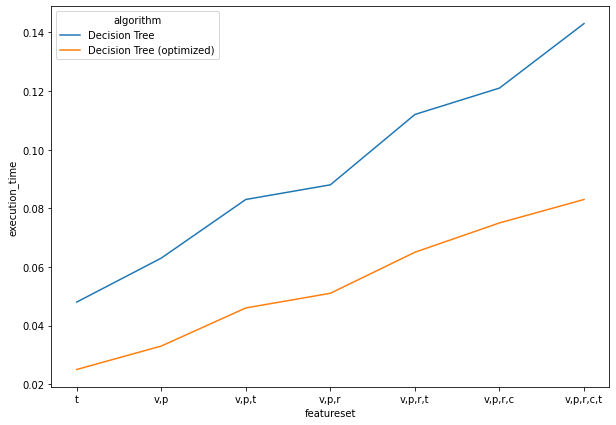

In [8]:
sns.lineplot(data=results_dt, x='featureset', y='execution_time', hue='algorithm')

### K nearest neigbour

Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

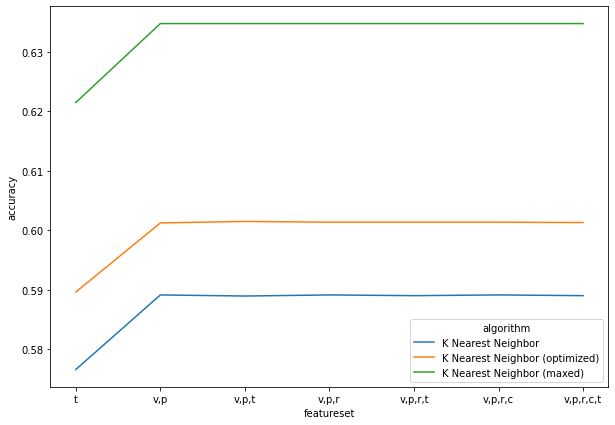

In [9]:
results_knn = results[results['algorithm'].str.contains('K Nearest Neighbor')]
sns.lineplot(data=results_knn, x='featureset', y='accuracy', hue='algorithm')

Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

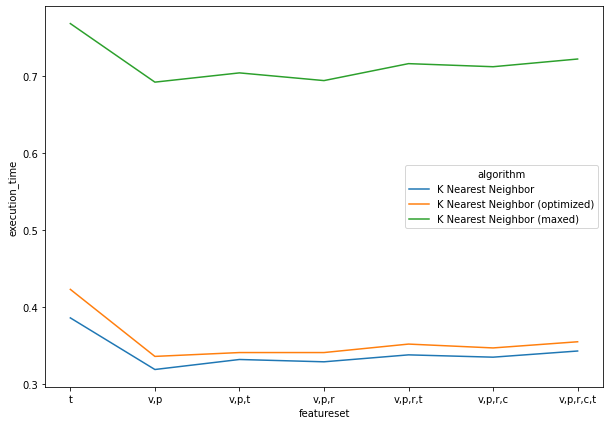

In [10]:
sns.lineplot(data=results_knn, x='featureset', y='execution_time', hue='algorithm')

### Random forest

Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

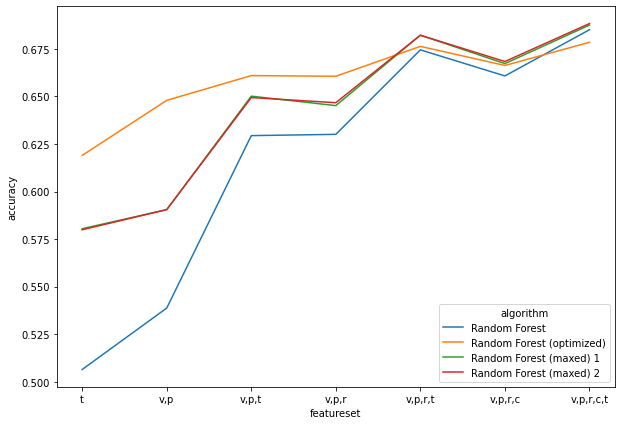

In [11]:
results_rf = results[results['algorithm'].str.contains('Random Forest')]
sns.lineplot(data=results_rf, x='featureset', y='accuracy', hue='algorithm')

Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

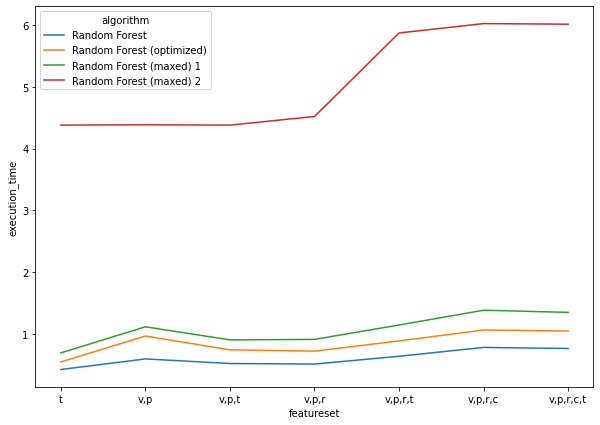

In [12]:
sns.lineplot(data=results_rf, x='featureset', y='execution_time', hue='algorithm')

### XG Boost

Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

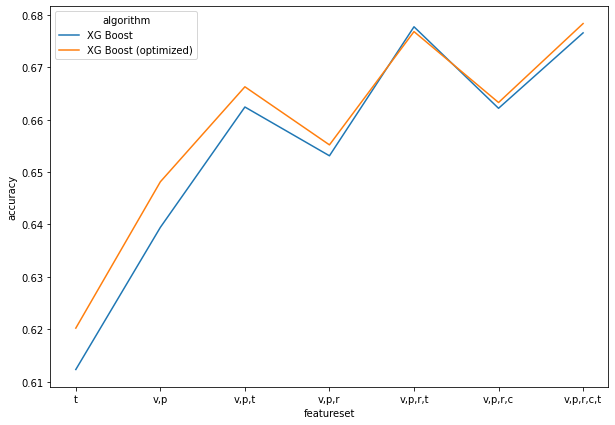

In [13]:
results_xgb = results[results['algorithm'].str.contains('XG Boost')]
sns.lineplot(data=results_xgb, x='featureset', y='accuracy', hue='algorithm')

Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

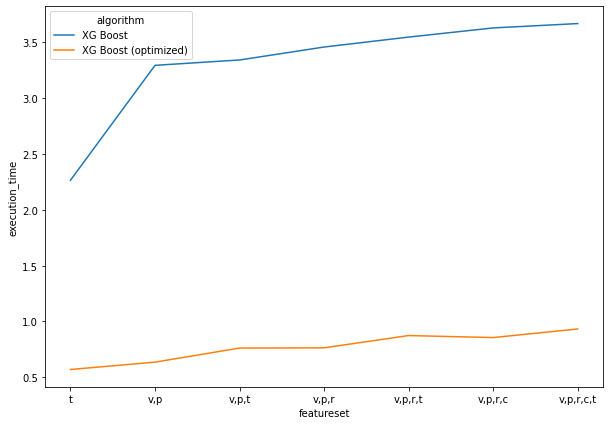

In [14]:
sns.lineplot(data=results_xgb, x='featureset', y='execution_time', hue='algorithm')